# GNN Implementation

- Name: Abhishek Aditya BS
- SRN: PES1UG19CS019
- VI Semester 'A' Section
- Date: 27-04-2022

In [51]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [52]:
import pandas as pd
import os


In [53]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [54]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt


In [55]:
dataset=sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [56]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [57]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [58]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects, train_size=140, test_size=None, stratify=node_subjects)
val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)

In [59]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [60]:
target_encoding=preprocessing.LabelBinarizer()

In [61]:
train_targets=target_encoding.fit_transform(train_subjects)
val_targets=target_encoding.transform(val_subjects)
test_targets=target_encoding.transform(test_subjects)

In [62]:
from stellargraph.mapper.full_batch_generators import FullBatchGenerator
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [63]:
train_gen=generator.flow(train_subjects.index, train_targets)

In [64]:
gcn=GCN(layer_sizes=[16,16], activations=['relu', 'relu'], generator=generator, dropout=0.5)

In [65]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices_2')>

In [66]:
predictions=layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [67]:
model=Model(inputs=x_inp, outputs=predictions)
model.compile(optimizer=optimizers.Adam(lr=0.01), loss=losses.categorical_crossentropy, metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping 

In [70]:
os_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [71]:
history = model.fit(train_gen, epochs=200, validation_data=val_gen, verbose=2, shuffle=False, callbacks=[os_callback])

Epoch 1/200
1/1 - 1s - loss: 1.9483 - acc: 0.1357 - val_loss: 1.9074 - val_acc: 0.3040 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 1.8903 - acc: 0.3500 - val_loss: 1.8605 - val_acc: 0.4040 - 89ms/epoch - 89ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8179 - acc: 0.4571 - val_loss: 1.8018 - val_acc: 0.4680 - 96ms/epoch - 96ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7500 - acc: 0.4571 - val_loss: 1.7377 - val_acc: 0.3960 - 84ms/epoch - 84ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6773 - acc: 0.4429 - val_loss: 1.6712 - val_acc: 0.3700 - 84ms/epoch - 84ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5647 - acc: 0.4143 - val_loss: 1.5990 - val_acc: 0.3760 - 84ms/epoch - 84ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4856 - acc: 0.5071 - val_loss: 1.5159 - val_acc: 0.4200 - 89ms/epoch - 89ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3913 - acc: 0.4786 - val_loss: 1.4307 - val_acc: 0.4860 - 88ms/epoch - 88ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2517 - acc: 0.6000 - val_loss: 1.3499 - val_acc: 0.5480 - 97ms/epoch - 97ms/s

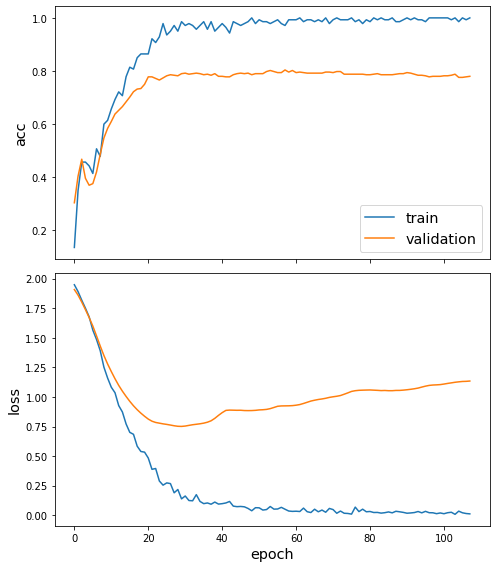

In [72]:
sg.utils.plot_history(history)

In [73]:
test_gen=generator.flow(test_subjects.index, test_targets)

In [74]:
all_nodes=node_subjects.index
all_gen=generator.flow(all_nodes)
all_predictions=model.predict(all_gen)

In [75]:
node_predictions=target_encoding.inverse_transform(all_predictions.squeeze())

In [79]:
df=pd.DataFrame({"Predicted":node_predictions, "True":node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [80]:
embedding_model=Model(inputs=x_inp, outputs=x_out)
emb=embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [81]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
X=emb.squeeze(0)
X.shape

(2708, 16)

In [82]:
transform = TSNE
trans=transform(n_components=2)
X_reduced=trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

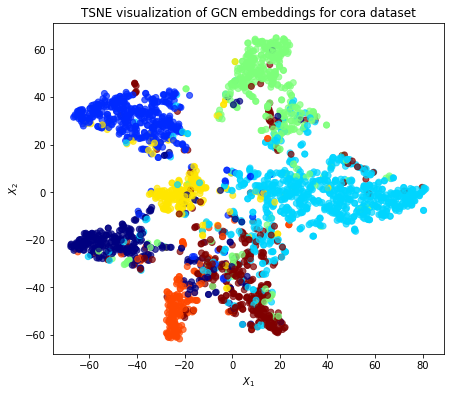

In [83]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)